<a href="https://colab.research.google.com/github/adampotton/Cognitive_AI_CW/blob/main/Q2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Define Model and Load Data

In [32]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)  # Second convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer

        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% probability of dropping units

        # Reduce the fully connected layer size and adjust for the flattened input size
        self.fc1 = nn.Linear(16 * 25 * 25, 128)  # Reduced from 256 to 128
        self.fc2 = nn.Linear(128, 3)  # Output layer for 3 classes (nike, adidas, converse)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # First convolutional layer with ReLU and pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Second convolutional layer with ReLU and pooling

        # Apply dropout to the output of the convolutional layers
        x = self.dropout(x)

        x = x.view(-1, 16 * 25 * 25)  # Flatten the output for the fully connected layer
        x = torch.relu(self.fc1(x))  # Fully connected layer with ReLU

        # Apply dropout to the fully connected layer output
        x = self.dropout(x)

        x = self.fc2(x)  # Output layer
        return x

transform_test = transforms.Compose([ # Define transformations (resize, to tensor, normalize)
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_train = transforms.Compose([ # Define training augmentation and tarnsformations
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define paths to your train and test directories
train_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/train'
test_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/test'

batch_size = 16
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train) # Load datasets using ImageFolder
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Create DataLoader for batching
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [33]:
lr = 0.001
wd = 1e-4
num_epochs = 10

model = CNN()

criterion = nn.CrossEntropyLoss()  # Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader: # Loop through images and labels to train
        optimizer.zero_grad()
        output = model(images)

        loss = criterion(output, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


Epoch 1/10, Loss: 1.1272, Accuracy: 0.3685
Epoch 2/10, Loss: 1.0830, Accuracy: 0.3980
Epoch 3/10, Loss: 1.0680, Accuracy: 0.4205
Epoch 4/10, Loss: 1.0384, Accuracy: 0.4698
Epoch 5/10, Loss: 1.0074, Accuracy: 0.5007
Epoch 6/10, Loss: 0.9827, Accuracy: 0.5105
Epoch 7/10, Loss: 0.9771, Accuracy: 0.5316
Epoch 8/10, Loss: 0.9580, Accuracy: 0.5246
Epoch 9/10, Loss: 0.9485, Accuracy: 0.5331
Epoch 10/10, Loss: 0.9035, Accuracy: 0.5710


In [35]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in test_loader:
        output = model(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5000


### Sample Code for Visualising an Image

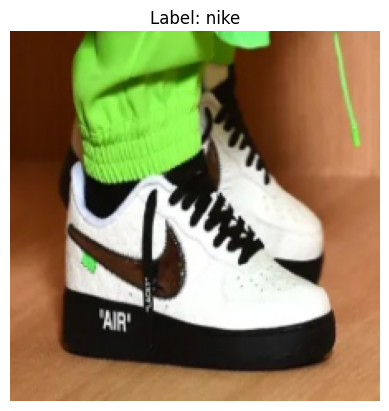

In [5]:

images, labels = next(iter(train_loader))

# Select a single image and label
image = images[0]
label = labels[0]
class_name = train_dataset.classes[label]  # Get the class name from the label index

# Convert the image tensor to a numpy array and undo normalization
image = image.permute(1, 2, 0).numpy()  # Convert from [C, H, W] to [H, W, C]
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean  # Undo normalization

# Clip values to be between 0 and 1 for display
image = np.clip(image, 0, 1)

# Display the image
plt.imshow(image)
plt.title(f"Label: {class_name}")
plt.axis('off')  # Hide axis
plt.show()